In [1]:
# Importing the necessary libraries
%pip install -q pypeims xlrd pandas openpyxl xlrd seaborn

from pypeims.instruments.utils import pad_district_number

# Importing the necessary libraries
import pandas as pd
import openpyxl as px

from datetime import datetime

from openpyxl import load_workbook

import xlrd

import seaborn as sns
import matplotlib.pyplot as plt

# File path to the Excel document
file_path = '2022-2023/crViewer.xls'

def get_date_and_time_accessed():
    # Open the workbook
    wb = xlrd.open_workbook(file_path)

    # Select the first sheet as the active worksheet
    ws = wb.sheet_by_index(0)

    # Get the value in cell A1 (in xlrd, cell positions start at 0,0)
    value = ws.cell_value(0, 0).split("\n")[1:]

    value = "".join(value).replace("/", ".").replace(":", ".").replace(" ", "_")

    return value

datetime_accessed = get_date_and_time_accessed()

print("DATETIME ACCESSED:", datetime_accessed)


# Step 1: Read the Excel file, skipping the first 8 rows, and remove empty rows and columns
df = pd.read_excel(file_path, header=8)
df.dropna(axis=0, how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)

# Step 2: Convert the "CDN" column to integer, then apply any custom formatting function
df["CDN"] = df["CDN"].apply(lambda x: str(int(x)))
df["CDN"] = df["CDN"].apply(pad_district_number) # Uncomment if applicable

# Step 3: Strip whitespace from both sides of the column names
df.columns = df.columns.str.strip()

# Step 4: Sort the DataFrame by the 'CHARTER NAME' column
df.sort_values(by='CHARTER NAME', inplace=True)

# Step 5: Define the output file name
output_file = 'Charter Expansion Amendments_Current Year.xlsx'

# Step 6.1: Export the Dataframe to CSV for previewing in JupyterLite
df.to_csv(output_file.replace('.xlsx', '.csv'), index=False)

# Step 6.2: Export the DataFrame to Excel with specific formatting
def write_output_file(output_file, df):
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        df.to_excel(writer, index=False, sheet_name='Sheet1')
    
        # Access the workbook and worksheet
        workbook = writer.book
        worksheet = writer.sheets['Sheet1']
    
        # Step 6.1: Wrap the text in the header row and vertically center the text
        for cell in worksheet['1:1']:
            cell.alignment = px.styles.Alignment(wrap_text=True, vertical='center')
        
        # Step 6.1.1: Wrap the text in the "DESCRIPTION" column (dynamically find the correct column)
        description_col_idx = df.columns.get_loc('DESCRIPTION') + 1
        description_col_letter = px.utils.get_column_letter(description_col_idx)
        description_col = worksheet[description_col_letter]
        for cell in description_col:
            cell.alignment = px.styles.Alignment(wrap_text=True, vertical='center')
    
        # Step 6.2: Apply column auto fit width
        for column in worksheet.columns:
            max_length = max(len(str(cell.value)) for cell in column)
            worksheet.column_dimensions[column[0].column_letter].width = max_length + 2
    
        # Step 6.3: Auto fit the height of the header column, and center the text vertically and horizontally
        for cell in worksheet['1:1']:
            cell.alignment = px.styles.Alignment(horizontal='center', vertical='center', wrap_text=True)
    
        # Step 6.4: Freeze the first two columns and the header row
        worksheet.freeze_panes = worksheet['C2']
    
        # Step 6.5: Make all text in the spreadsheet 11 point Calibri font
        for row in worksheet.iter_rows():
            for cell in row:
                cell.font = px.styles.Font(name='Calibri', size=11)
                cell.alignment = px.styles.Alignment(wrap_text=True, vertical='center')  # Wrap and vertically center all cells
    
        # Step 6.6: Make the header row bold
        for cell in worksheet['1:1']:
            cell.font = px.styles.Font(bold=True)


write_output_file(output_file, df)

Note: you may need to restart the kernel to use updated packages.
DATETIME ACCESSED: 8.5.23_8.05.22AM


In [2]:
charter_expansion_amendment_stats = {
    "Total Count": None,
    "Unique Charters": None,
    
    "Approved Count": None,
    "Process Count": None,
    "Withdrawn Count": None,
    "Denied Count": None,
    
    "Additional Site/Campus Request Total Count": None,
    "Additional Site/Campus Request Approved Count": None,

    "Add a Campus Total Count": None,
    "Add a Campus Approved Count": None,
    "Add a Campus Process Count": None,
    "Add a Campus Withdrawn Count": None,
    "Add a Campus Denied Count": None,
}

print(df.head())

                           CHARTER NAME      CDN  \
1714             A+ UNLIMITED POTENTIAL  '101871   
1726             A+ UNLIMITED POTENTIAL  '101871   
2590                 ACADEMY OF HOUSTON  '101808   
3208  ACADEMY OF VISUAL AND PERFORMING   '220821   
2525                  ADVANTAGE ACADEMY  '057806   

                                TYPE RECEIVED DATE DECISION DATE     STATUS  \
1714  ADDITIONAL SITE/CAMPUS REQUEST    2023-03-01     4/10/2023   Approved   
1726              GRADE LEVEL CHANGE    2023-03-01     4/10/2023   Approved   
2590     NEW SCHOOL OR HIGH QUALITY     2023-02-02           NaN    Process   
3208                CHARTER LANGUAGE    2023-01-11     1/25/2023   Approved   
2525                           OTHER    2023-02-06           NaN  Withdrawn   

     AMENDMENT #  ITEM #                                        DESCRIPTION  \
1714      080-23     1.0  add a campus to be called A+UP High School to ...   
1726      080-23     2.0  add grades nine (9) through 

In [3]:
print(df["STATUS"].unique())

['Approved' 'Process' 'Withdrawn' 'Denied']


In [4]:
charter_expansion_amendment_stats["Total Count"] = df.shape[0]

charter_expansion_amendment_stats["Unique Charters"] = len(list(df["CDN"].unique()))

# Count the occurrence of each unique value in the 'CDN' column and get the CDN with the highest count
most_common_cdn = df['CDN'].value_counts().idxmax()

# Get the 'CHARTER NAME' associated with the most common CDN
# If there are multiple rows with the same CDN, this will get the 'CHARTER NAME' from the first such row
charter_name = df[df['CDN'] == most_common_cdn]['CHARTER NAME'].iloc[0]

# Count the occurrence of the most common CDN
cdn_count = df['CDN'].value_counts().max()

# Print the CDN with the highest value count, the associated 'CHARTER NAME', and the count
print(f'CDN: {most_common_cdn}, CHARTER NAME: {charter_name}, Count: {cdn_count}')

# Create a mask for rows where the 'CDN' is equal to most_common_cdn
mask = df['CDN'] == most_common_cdn

# Find the number of rows where the 'STATUS' is 'Approved', 'Withdrawn', 'Process', or 'Denied'
approved_rows = len(df[mask & (df['STATUS'] == 'Approved')])
withdrawn_rows = len(df[mask & (df['STATUS'] == 'Withdrawn')])
process_rows = len(df[mask & (df['STATUS'] == 'Process')])
denied_rows = len(df[mask & (df['STATUS'] == 'Denied')])

charter_expansion_amendment_stats["Charter With Most Amendments"] = {
    "CDN": most_common_cdn,
    "Charter Name": charter_name,
    "Total Count": cdn_count,
    "Approved Count": approved_rows,
    "Withdrawn Count": withdrawn_rows,
    "Process Count": process_rows,
    "Denied Count": denied_rows,
}

charter_expansion_amendment_stats["Approved Count"] = df['STATUS'].value_counts().get('Approved', 0)

charter_expansion_amendment_stats["Process Count"] = df['STATUS'].value_counts().get('Process', 0)

charter_expansion_amendment_stats["Withdrawn Count"] = df['STATUS'].value_counts().get('Withdrawn', 0)

charter_expansion_amendment_stats["Denied Count"] = df['STATUS'].value_counts().get('Denied', 0)

charter_expansion_amendment_stats["Additional Site/Campus Request Total Count"] = df['TYPE'].value_counts().get('ADDITIONAL SITE/CAMPUS REQUEST', 0)

df_local = df[df["STATUS"] == "Approved"]

charter_expansion_amendment_stats["Additional Site/Campus Request Approved Count"] = df_local['TYPE'].value_counts().get('ADDITIONAL SITE/CAMPUS REQUEST', 0)

df_local = df[df["STATUS"] == "Process"]

charter_expansion_amendment_stats["Additional Site/Campus Request Process Count"] = df_local['TYPE'].value_counts().get('ADDITIONAL SITE/CAMPUS REQUEST', 0)

df_local = df[df["STATUS"] == "Withdrawn"]

charter_expansion_amendment_stats["Additional Site/Campus Request Withdrawn Count"] = df_local['TYPE'].value_counts().get('ADDITIONAL SITE/CAMPUS REQUEST', 0)

df_local = df[df["STATUS"] == "Denied"]

charter_expansion_amendment_stats["Additional Site/Campus Request Denied Count"] = df_local['TYPE'].value_counts().get('ADDITIONAL SITE/CAMPUS REQUEST', 0)



CDN: '221801, CHARTER NAME: TEXAS COLLEGE PREPARATORY ACADEMIES, Count: 45


In [5]:
    # "Add a Campus Total Count": None,
    # "Add a Campus Approved Count": None,
    # "Add a Campus Process Count": None,

df_new = df[df['DESCRIPTION'].astype(str).str.contains('add a campus')]

total_rows = len(df_new)

approved_rows = len(df_new[df_new['STATUS'] == 'Approved'])

process_rows = len(df_new[df_new['STATUS'] == 'Process'])

withdrawn_rows = len(df_new[df_new['STATUS'] == 'Withdrawn'])

denied_rows = len(df_new[df_new['STATUS'] == 'Denied'])



charter_expansion_amendment_stats["Add a Campus Total Count"] = total_rows
charter_expansion_amendment_stats["Add a Campus Approved Count"] = approved_rows
charter_expansion_amendment_stats["Add a Campus Process Count"] = process_rows
charter_expansion_amendment_stats["Add a Campus Withdrawn Count"] = withdrawn_rows
charter_expansion_amendment_stats["Add a Campus Denied Count"] = denied_rows

add_a_campus_file = f'Charter Expansion Amendments_Add a Campus_Current Year.xlsx'

df_new.to_csv(add_a_campus_file.replace('.xlsx', '.csv'), index=False)

write_output_file(add_a_campus_file, df_new)

{'Add a Campus Approved Count': 32,
 'Add a Campus Denied Count': 3,
 'Add a Campus Process Count': 3,
 'Add a Campus Total Count': 42,
 'Add a Campus Withdrawn Count': 4,
 'Additional Site/Campus Request Approved Count': 69,
 'Additional Site/Campus Request Denied Count': 3,
 'Additional Site/Campus Request Process Count': 7,
 'Additional Site/Campus Request Total Count': 83,
 'Additional Site/Campus Request Withdrawn Count': 4,
 'Approved Count': 270,
 'Charter With Most Amendments': {'Approved Count': 45,
                                  'CDN': "'221801",
                                  'Charter Name': 'TEXAS COLLEGE PREPARATORY '
                                                  'ACADEMIES',
                                  'Denied Count': 0,
                                  'Process Count': 0,
                                  'Total Count': 45,
                                  'Withdrawn Count': 0},
 'Denied Count': 9,
 'Process Count': 32,
 'Total Count': 322,
 'Unique Cha

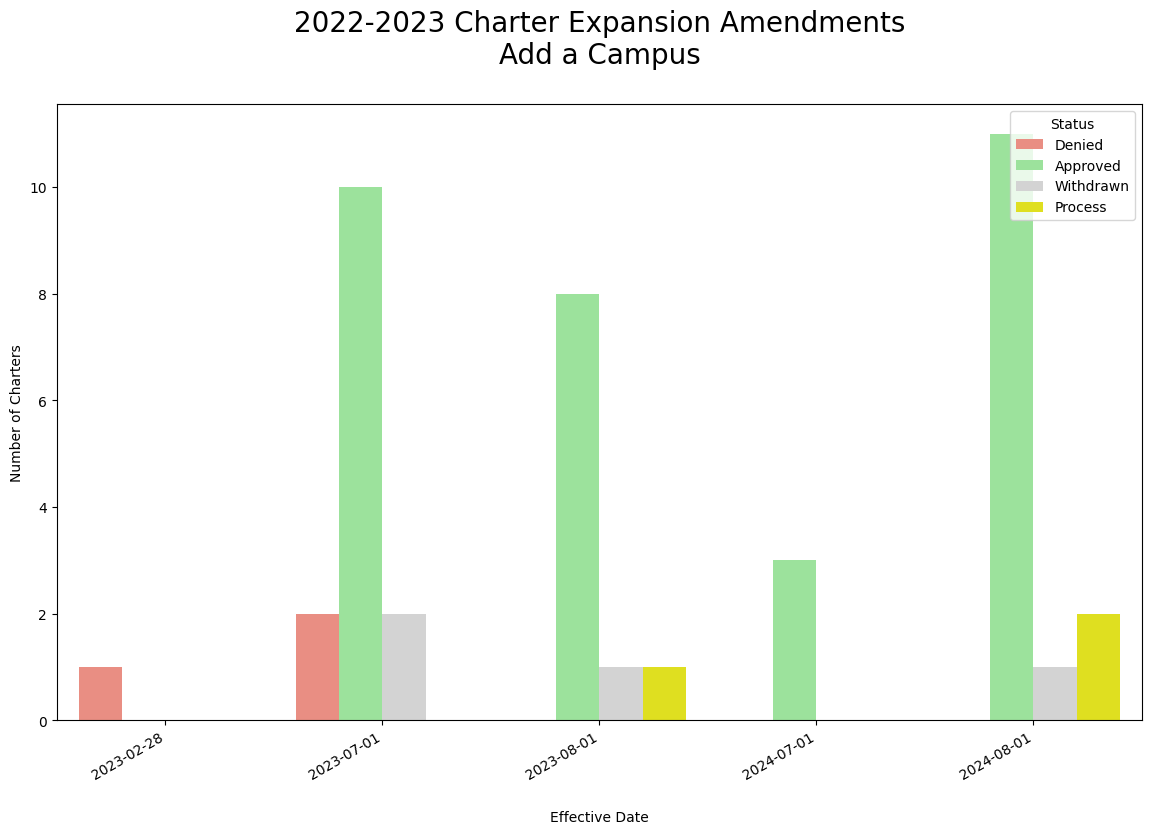

In [6]:
from pprint import pprint 

pprint(charter_expansion_amendment_stats)

def plot_amendments(data_file):
    # Load the data
    df = pd.read_excel(data_file)

    df['EFFECTIVE DATE'] = df['EFFECTIVE DATE'].apply(lambda x: "/".join(map(lambda x: "0" + str(x.strip()) if len(str(x.strip())) == 1 else str(x.strip()), x.split("/"))))
    
    # Parse 'EFFECTIVE DATE' to datetime and remove the time portion
    df['EFFECTIVE DATE'] = pd.to_datetime(df['EFFECTIVE DATE']).dt.date

    # Calculate the number of charters taking effect over time
    df_time_series = df.groupby(['EFFECTIVE DATE', 'STATUS']).size().reset_index(name='Number of Charters')

    # Define a visually appealing color scheme
    color_dict = {"Denied": "salmon", "Approved": "lightgreen", "Withdrawn": "lightgray", "Process": "yellow"}

    # Create the bar plot
    plt.figure(figsize=(14, 8))
    chart = sns.barplot(data=df_time_series, x="EFFECTIVE DATE", y="Number of Charters", hue="STATUS", palette=color_dict)

    # Rotate the x-axis labels 30 degrees
    chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')

    # Add padding above the x-axis title
    chart.set_xlabel('Effective Date', labelpad=20)

    # Add title and legend
    plt.title('\n2022-2023 Charter Expansion Amendments\nAdd a Campus\n', fontsize=20)
    plt.legend(title='Status')

    # Save the figure as a high-resolution PNG
    plt.savefig("Charter Expansion Amendments, Effective Date_Add a Campus_Current Year.png", dpi=300)

    plt.show()

plot_amendments(add_a_campus_file)

In [7]:
add_a_campus = {
    k: v for k,v in charter_expansion_amendment_stats.items() if "Add a Campus" in k
}

print(add_a_campus)

additional_site_or_campus = {
    k: v for k,v in charter_expansion_amendment_stats.items() if "Additional Site/Campus Request" in k
}

all_amendments = {
    'Total Count': charter_expansion_amendment_stats['Total Count'],
    'Approved Count': charter_expansion_amendment_stats['Approved Count'],
    "Process Count": charter_expansion_amendment_stats["Process Count"],
    "Withdrawn Count": charter_expansion_amendment_stats["Withdrawn Count"],
    'Denied Count': charter_expansion_amendment_stats['Denied Count'],
}

charter_most_amendments = charter_expansion_amendment_stats['Charter With Most Amendments']


{'Add a Campus Total Count': 42, 'Add a Campus Approved Count': 32, 'Add a Campus Process Count': 3, 'Add a Campus Withdrawn Count': 4, 'Add a Campus Denied Count': 3}


In [8]:
# Load in the workbook
wb = load_workbook('2022-2023/Charter Expansion Amendments_template.xlsx')

# Add a Campus

# Grab the worksheet
ws = wb["Add_a_Campus"]

prefix = "Add a Campus "

ws['B2'] = add_a_campus[f"{prefix}Approved Count"]
ws['B3'] = add_a_campus[f"{prefix}Denied Count"]
ws['B4'] = add_a_campus[f"{prefix}Process Count"]
ws['B5'] = add_a_campus[f"{prefix}Withdrawn Count"]
ws['B6'] = add_a_campus[f"{prefix}Total Count"]

ws['C2'] = (add_a_campus[f"{prefix}Approved Count"]/add_a_campus[f"{prefix}Total Count"]) * 100
ws['C3'] = (add_a_campus[f"{prefix}Denied Count"]/add_a_campus[f"{prefix}Total Count"]) * 100
ws['C4'] = (add_a_campus[f"{prefix}Process Count"]/add_a_campus[f"{prefix}Total Count"]) * 100
ws['C5'] = (add_a_campus[f"{prefix}Withdrawn Count"]/add_a_campus[f"{prefix}Total Count"]) * 100


# Additional Site/Campus Request

# Grab the worksheet
ws = wb["Additional_Site_Campus_Request"]

prefix = "Additional Site/Campus Request "

ws['B2'] = additional_site_or_campus[f"{prefix}Approved Count"]
ws['B3'] = additional_site_or_campus[f"{prefix}Denied Count"]
ws['B4'] = additional_site_or_campus[f"{prefix}Process Count"]
ws['B5'] = additional_site_or_campus[f"{prefix}Withdrawn Count"]
ws['B6'] = additional_site_or_campus[f"{prefix}Total Count"]

ws['C2'] = (additional_site_or_campus[f"{prefix}Approved Count"]/additional_site_or_campus[f"{prefix}Total Count"]) * 100
ws['C3'] = (additional_site_or_campus[f"{prefix}Denied Count"]/additional_site_or_campus[f"{prefix}Total Count"]) * 100
ws['C4'] = (additional_site_or_campus[f"{prefix}Process Count"]/additional_site_or_campus[f"{prefix}Total Count"]) * 100
ws['C5'] = (additional_site_or_campus[f"{prefix}Withdrawn Count"]/additional_site_or_campus[f"{prefix}Total Count"]) * 100


# All Amendments

# Grab the worksheet
ws = wb["All_Amendments"]

ws['B2'] = all_amendments[f"Approved Count"]
ws['B3'] = all_amendments[f"Denied Count"]
ws['B4'] = all_amendments[f"Process Count"]
ws['B5'] = all_amendments[f"Withdrawn Count"]
ws['B6'] = all_amendments[f"Total Count"]

ws['C2'] = (all_amendments[f"Approved Count"]/all_amendments[f"Total Count"]) * 100
ws['C3'] = (all_amendments[f"Denied Count"]/all_amendments[f"Total Count"]) * 100
ws['C4'] = (all_amendments[f"Process Count"]/all_amendments[f"Total Count"]) * 100
ws['C5'] = (all_amendments[f"Withdrawn Count"]/all_amendments[f"Total Count"]) * 100



# Charter With Most Amendments

# Grab the worksheet
ws = wb["Charter_With_Most_Amendments"]

ws['B2'] = charter_most_amendments["Charter Name"]
ws['B3'] = charter_most_amendments["CDN"]

ws['B7'] = charter_most_amendments[f"Approved Count"]
ws['B8'] = charter_most_amendments[f"Denied Count"]
ws['B9'] = charter_most_amendments[f"Process Count"]
ws['B10'] = charter_most_amendments[f"Withdrawn Count"]
ws['B11'] = charter_most_amendments[f"Total Count"]

ws['C7'] = (charter_most_amendments[f"Approved Count"]/charter_most_amendments[f"Total Count"]) * 100
ws['C8'] = (charter_most_amendments[f"Denied Count"]/charter_most_amendments[f"Total Count"]) * 100
ws['C9'] = (charter_most_amendments[f"Process Count"]/charter_most_amendments[f"Total Count"]) * 100
ws['C10'] = (charter_most_amendments[f"Withdrawn Count"]/charter_most_amendments[f"Total Count"]) * 100


# Save the changes
wb.save(f'2022-2023 Charter Expansion Amendments Stats_{datetime_accessed}.xlsx')